# Simulating lattice gauge theory with Rydberg atoms

In [notebook 00](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/00_Introduction_of_Analog_Hamiltonian_Simulation_with_Rydberg_Atoms.ipynb), we introduced a component of analog Hamiltonian simulations (AHS) with Rydberg atom, namely the local detuning that detunes the atoms according to a non-uniform pattern. This is different from the global driving field, which has been the main focus of previous notebooks, that addresses all the atoms simultaneously and uniformly. Here, we illustrate an important use case for the local detuning, which is initial state preparation, in the context of simulating lattice gauge theory (LGT). This notebook is inspired by the paper [F. M. Surace et al. (10.1103/PhysRevX.10.021041)](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.10.021041).

## Background: The propagation of particle-antiparticle pairs in LGT

Specifically, we are interested in simulating the propagation of a particle-antiparticle pair in LGT. For that, we will use the so-called quantum link model formulation of the LGT, where the states of an atom are interpreted as left or right pointing electric fields, and the bonds between neighboring atoms are interpreted as particles or antiparticles depending on the configurations. 

More specifically, the Rydberg states at the odd (even) sites are interpreted as electric fields pointing to the left (right), whereas the ground states at the odd (even) sites are electric field pointing to the right (left). The electric fields correspond to the red and blue arrows in the figure shown below. The bonds between the atoms are interpreted as particles or antiparticles. If the electric fields are diverging at a bond, then it is particle, otherwise if the electric field is converging, the bond is an antiparticle. There is no particle if the left and right electric fields are pointing in the same direction, or we interpret the bond as a vacuum. This is similar to positive charge and negative charge have outward and inward pointing electric fields respectively. The mapping is summarized in the following figure (source: [F. M. Surace et al. (10.1103/PhysRevX.10.021041)](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.10.021041)).

<!-- Further, the bond between an odd and an even indexed atoms corresponds to an antiparticle if both atoms are in the ground states, otherwise it is interpreted as a vacuum state. On the other hand, the bond between an even and an odd indexed atoms corresponds to a particle if both atoms are in the ground states, otherwise it is interpreted as a vacuum. The mapping is summarized in the following figure (source: [F. M. Surace et al. (10.1103/PhysRevX.10.021041)](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.10.021041)). -->

![LGT_mapping.png](LGT_mapping.png)

Using the above mapping, we can interpret the 1D $Z_2$ state (see [notebook 02](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/02_Ordered_phases_in_Rydberg_systems.ipynb)) as the so-called "anti-string" state with all electric fields pointing in the same direction. In order to prepare the particle-antiparticle pair, we will need to prepare a defect in the anti-string state: The domain walls between anti-string and string states will host particles, whereas those between string and anti-string states will host anti-particles. Interestingly, the particle and antiparticle always come in pairs, and their time evolution exhibits light cones, in which the string-antistring oscillation is out-of-phase compared to that outside of the light cone. This is illustrated below (source: [F. M. Surace et al. (10.1103/PhysRevX.10.021041)](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.10.021041)).

<div>
<img src="LGT_particle_antiparticle_propagation.png" width="800"/>
</div>

In this notebook, we will use the local detuning, together with the driving field, to create a 1D $Z_2$ ordered state with a defect in the center. This is the desired initial state with a particle-antiparticle pair. After that, we turn off the local detuning, and let the atoms continue to evolve under the constant driving field. From the mapping between the Rydberg atoms and LGT described above, we anticipate that the average Rydberg density of the atomic chain will exhibit a pattern that resembles a light cone.

To begin, we import the necessary packages.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

In [2]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.timings import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.local_detuning import LocalDetuning

from ahs_utils import (
    show_drive_and_local_detuning, 
    show_final_avg_density, 
)

import numpy as np
import matplotlib.pylab as plt
import time

from braket.devices import LocalSimulator
simulator = LocalSimulator("braket_ahs")

Let's define certain device-specific constraints, such as maximum values for the Rabi frequency and local detuning.

In [3]:
omega_max = 15800000.0 # rad / seconds
omega_slew_rate_max = 250000000000000.0 # rad / seconds / seconds
tmin = 5e-08 # seconds

local_detuning_max = (2*np.pi*7.5)*1e6 # rad / seconds
local_detuning_slew_rate_max = (2*np.pi*7.5)*1e12 # rad / seconds / seconds

t_ramp_omega = omega_max/omega_slew_rate_max # seconds
t_ramp_local_detuning = local_detuning_max/local_detuning_slew_rate_max # seconds

detuning_max = 125000000.0 # rad / seconds

## Define atom arrangement

We first prepare a 1D chain of atoms. Since we would like to create a defect that is symmetrically centered at the chain, the length of the chain should be $4n+1$ for integer n. 

In [4]:
N = 9 # 4n+1
a = 5.5e-6
register = AtomArrangement()
for ind in range(N):
    register.add([0, ind * a])


# Prepare the state with particle-antiparticle pair

There are several approaches to prepare a 1D $Z_2$ state with a defect at the center. Here we will subject the chain of atoms with a $\pi$-pulse, together with positive local detuning on the odd indexed atoms and the center atoms. Because these atoms are strongly detuned away from resonance, they will remain in the ground states whereas the rest of the atoms are excited to the Rydberg states. 

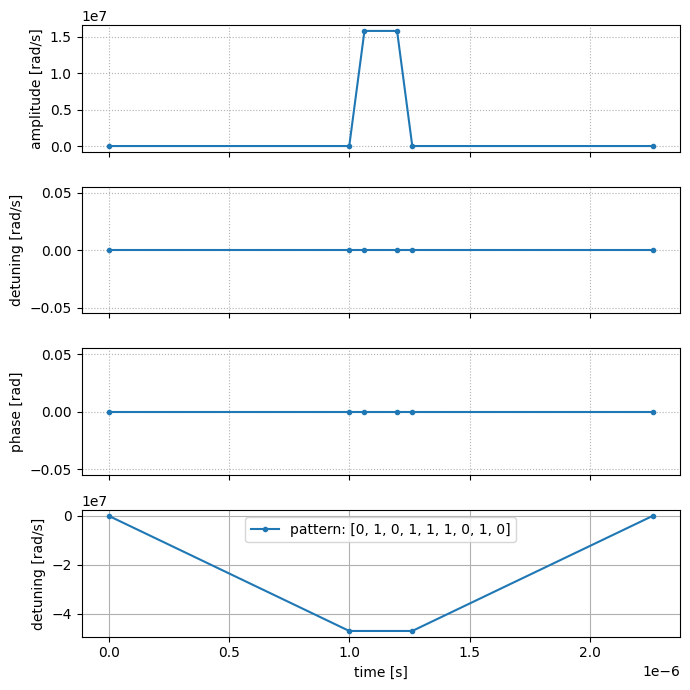

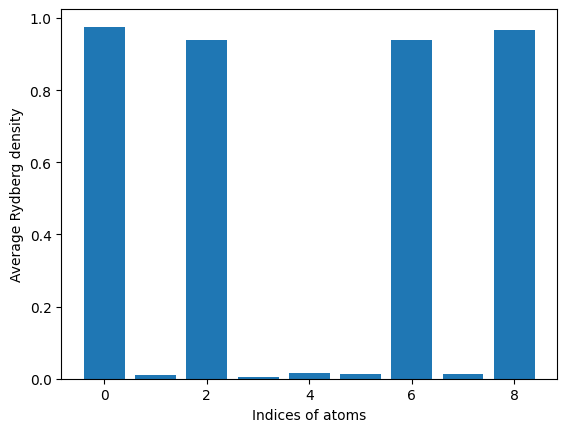

In [5]:
def prepare_states(
    indices, 
    omega_max=omega_max, 
    omega_slew_rate_max=omega_slew_rate_max, 
    local_detuning_max=local_detuning_max,
    register=register,    
    run_and_show = True
):
    """
    Return the driving field and local detuning for preparing the initial state
    
    Args:
        indices: A list of atoms that are in the rydberg states
        omega_max: The maximum value of the Rabi frequency
        omega_slew_rate: The maximum value of the slew rate for the Rabi frequency
        local_detuning_max: The maximum value of the local detuning
        register: The register for the anlog Hamiltonian simulation program
        run_and_show: If true, run the anlog Hamiltonian simulation program 
            and show the final average density
            
    Returns:
        drive: The driving field to prepare the initial state
        local_detuning: The local detuning to prepare the initial state        
        
    """

    amplitude = TimeSeries.trapezoidal_signal(np.pi, omega_max, omega_slew_rate_max)
    drive_time_points, amplitude_values = amplitude.times(), amplitude.values()

    drive_time_points = np.array(drive_time_points) + t_ramp_local_detuning
    drive_time_points = np.insert(drive_time_points, 0, 0.0)
    drive_time_points = np.insert(drive_time_points, len(drive_time_points), drive_time_points[-1]+t_ramp_local_detuning)

    amplitude_values = np.array(amplitude_values)
    amplitude_values = np.insert(amplitude_values, 0, 0.0)
    amplitude_values = np.insert(amplitude_values, len(amplitude_values), 0.0)

    phase_values = [0 for _ in range(len(drive_time_points))]
    detuning_values = [0 for _ in range(len(drive_time_points))]

    drive = DrivingField.from_lists(drive_time_points, amplitude_values, detuning_values, phase_values)

    pattern = [1 for _ in range(len(register))]
    for ind in indices:
        pattern[ind] = 0

    local_detuning_time_points = [0, t_ramp_local_detuning, drive_time_points[-1] - t_ramp_local_detuning, drive_time_points[-1]]
    local_detuning_values = [0, -local_detuning_max, -local_detuning_max, 0]

    local_detuning = LocalDetuning.from_lists(local_detuning_time_points, local_detuning_values, pattern)

    show_drive_and_local_detuning(drive, local_detuning)    

    if run_and_show:
        ahs_program = AnalogHamiltonianSimulation(
            hamiltonian=drive + local_detuning,
            register=register
        )

        result = simulator.run(ahs_program, shots=1000, steps=100).result()
        show_final_avg_density(result)
        
    return drive, local_detuning

indices_ryd = [i for i in range(N) if np.mod(i, 2) == 0 and i != N // 2]

drive_initial_state, local_detuning_initial_state = prepare_states(indices_ryd)

# Particle-antiparticle pair propagation

From the above figures, we confirmed that it is possible to prepare the $Z_2$ state with a defect at the center with the help of the local detuning. We now turn off the local detuning, and observe how the Rydberg densities evolve under a constant global driving field.

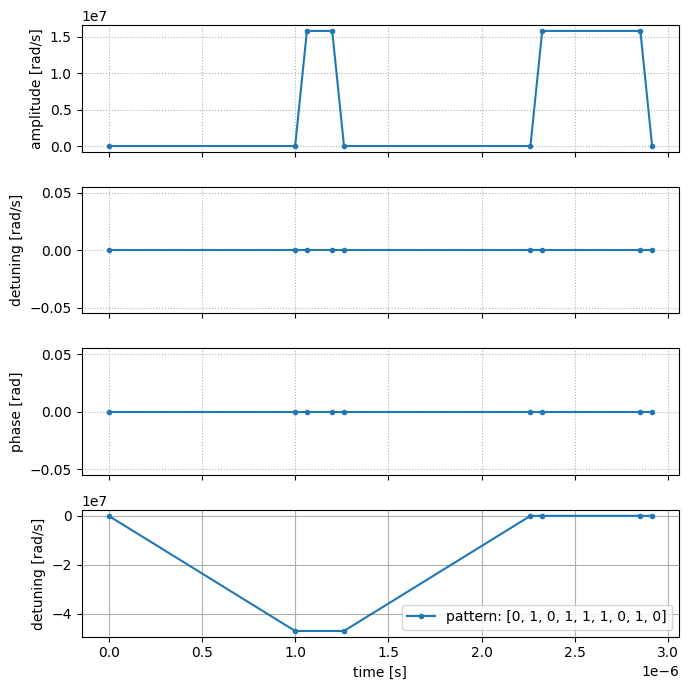

In [6]:
trange = np.linspace(0, 1e-6, 20)
programs = []
trange2 = []


for ind_t, t in enumerate(trange):
    
    time_points = [0, t_ramp_omega, t_ramp_omega + t, 2 * t_ramp_omega + t]
    amplitude_values = [0, omega_max, omega_max, 0]
    phase_values = [0, 0, 0, 0]
    detuning_values = [0, 0, 0, 0]    
    local_detuning_values = [0, 0, 0, 0]
    
    drive_propagation = DrivingField.from_lists(time_points, amplitude_values, detuning_values, phase_values)
    drive = drive_initial_state.stitch(drive_propagation)
    
    local_detuning_propagation = LocalDetuning.from_lists(time_points, local_detuning_values, local_detuning_initial_state.magnitude.pattern.series)
    local_detuning = local_detuning_initial_state.stitch(local_detuning_propagation) 
    
    programs.append(
        AnalogHamiltonianSimulation(
            hamiltonian=drive + local_detuning,
            register=register
        )
    )
    trange2.append(drive.amplitude.time_series.times()[-1])   
    
    # Show an example for the full program
    if ind_t == len(trange) // 2:
        show_drive_and_local_detuning(drive, local_detuning)


In the above plots, we have shown a full AHS program as an example, including the preparation of initial state and the evolution of the evolution subject to the constant global driving field. We are now ready to run the programs on the local simulator, and the result is plot below.

In [7]:
start_time = time.time()
densities = []
for ind, program in enumerate(programs):
    result = simulator.run(program, shots=1000, steps=20).result()
    densities.append(result.get_avg_density())
    
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 30.483916997909546 seconds


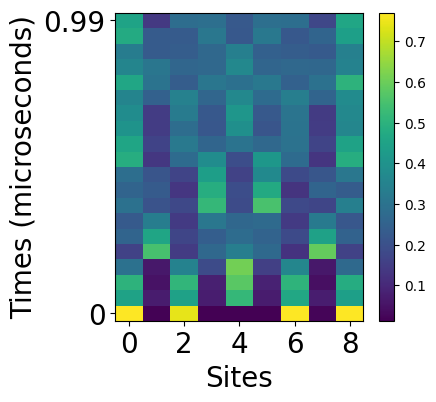

In [8]:
plt.figure(figsize = (4,4))
shw=plt.imshow(densities[::-1], aspect='auto')
plt.xlabel("Sites", fontsize=20)
plt.ylabel("Times (microseconds)", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([len(trange2)-1, 0], ["0", f"{ ( trange2[-1] - trange2[0] ) * 1e6}"[:4]])
bar = plt.colorbar(shw)
plt.show()


Indeed, we can see that the average Rydberg density exhibit a light cone pattern, as a function of time. The light cone originates from the center of the chain, where the defect is located. The light cone separates two regions where the oscillations of the Rydberg and ground states are out of phase. From the mapping between the Rydberg atoms and LGT, we can interpret the light cone as the result of counter propagation of the particle-antiparticle pair in the two dimensional spacetime. 

## Simulating the LGT on a QPU

In previous sections, we have demonstrated how to simulate the LGT with the Rydberg atoms. The results from the local simulator show that the results of the programs meet our expectations. Here we will run the same AHS programs on a quantum device.

<div class="alert alert-block alert-info">
<b>Note: </b> Since it will take sometime before we can receive the result back from the quantum device, it is suggested to save the task ARN for retrieving the task result in a later time. 
</div>

In [9]:
from braket.aws import AwsDevice 
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

In [10]:
task_arns = []
for ind, program in enumerate(programs):
    task = qpu.run(program.discretize(qpu), shots=100)
    task_arn = task.metadata()['quantumTaskArn']
    task_arns.append(task_arn)
    

We can extract the results based on the task arns

In [11]:
from braket.aws import AwsQuantumTask

densities_qpu = []
for task_arn in task_arns:
    result_qpu = AwsQuantumTask(arn=task_arn).result()
    densities_qpu.append(result_qpu.get_avg_density())

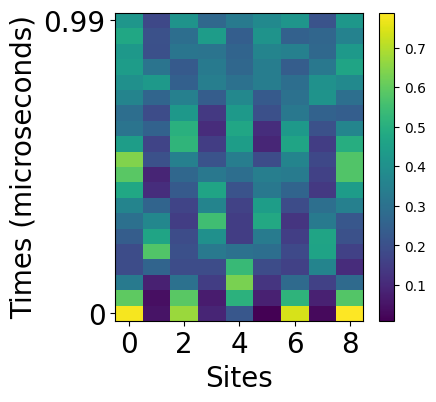

In [12]:
plt.figure(figsize = (4,4))
shw=plt.imshow(densities_qpu[::-1], aspect='auto')
plt.xlabel("Sites", fontsize=20)
plt.ylabel("Times (microseconds)", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([len(trange2)-1, 0], ["0", f"{(trange2[-1]-trange2[0])*1e6}"[:4]])
bar = plt.colorbar(shw)
plt.show()


## Conclusion

In this example, we have demonstrated how to prepare a 1D $Z_2$ state with a defect, the key step for simulating the particle-antiparticle propagation in LGT. The local detuning can be used to prepare other states of interest, provided that it respects the Rydberg blockade constraint. This capability opens the door for many applications of AHS with Rydberg atoms.

In [13]:
print("Task Summary")
print(tracker.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{'arn:aws:braket:us-east-1::device/qpu/quera/Aquila': {'shots': 2000, 'tasks': {'COMPLETED': 20}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 26.00 USD
